## Multiple linear regression(MLR) Stochastic Gradient Descent(SGD),
### with optuna and StandardScaler and 11+7 new features
on subsampled dataset with 3fold un shuffled cv
20220930

In [1]:
import pandas as pd
import numpy as np
import random
import optuna as opt
import time
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
#import data
train_df = pd.read_parquet("train_main.parquet.snappy")
test_df = pd.read_parquet("test_main.parquet.snappy")

In [3]:
test_df

,r_id,r_stars,r_stars_square,r_length,u_friends_count,u_review_count,u_month_age,u_comp_avg,u_n_elite_yrs,u_fans,u_avg_stars,u_give_useful,b_stars,b_review_count,b_days_open_wk,b_hours_open_wk,r_sen,r_sub,r_rea,r_useful
0,2392151,4,16,235,91,108,3.528048,0.527778,3,4,3.69,127,3.5,293,7.0,87.5,0.035417,0.161285,87.55,1
1,1503740,3,9,157,107,39,0.336006,0.512821,0,3,3.16,106,2.5,1249,7.0,168.0,0.147890,0.419108,93.95,1
2,5868535,4,16,355,60,70,26.598261,0.071429,0,0,4.29,66,2.5,43,NaN,NaN,0.128257,0.418071,78.28,1
3,5873696,5,25,36,1,20,84.829250,0.100000,0,0,4.10,8,4.0,11,6.0,68.0,0.256818,0.538159,78.59,1
4,3475838,4,16,64,180,258,87.693135,0.279070,6,35,4.16,543,5.0,5,7.0,56.0,0.270139,0.456944,94.45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1938885,5,25,46,55,244,79.494907,0.540984,4,18,3.95,562,5.0,11,5.0,38.5,0.250000,0.250000,87.52,1
99996,5546501,5,25,122,224,18,9.216592,0.055556,0,0,3.89,4,4.0,1822,5.0,47.0,0.433681,0.445833,81.33,1
99997,2679011,1,1,25,1,2,7.442104,0.000000,0,0,1.00,3,3.0,381,7.0,90.5,-0.225000,0.250000,73.85,1
99998,3963237,1,1,99,1,6,72.006629,0.000000,0,0,2.67,8,1.5,747,6.0,52.0,0.000000,0.378571,74.49,1


In [4]:
X_train = train_df.drop(['r_id','r_useful'],axis=1)
y_train = train_df['r_useful']
X_test = test_df.drop(['r_id','r_useful'],axis=1)
y_test = test_df['r_useful']

In [5]:
random.seed(760)

In [6]:
def objective(trial):
    start = time.time()
    params = {
        "alpha": trial.suggest_float('alpha', 0.00001, 0.002),
        "eta0": trial.suggest_float('eta0', 0.001, 0.05),
        "power_t": trial.suggest_float('power_t', 0.1, 0.3),
        "learning_rate" : trial.suggest_categorical("learning_rate", ['constant', 'optimal', 'invscaling', 'adaptive']),
    }
    print("Currently running with:")
    print(params)
    
    pipe = Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), ('mlr', SGDRegressor(**params))])
    
    # model.fit(X_train, y_train)
    cvscore = np.sqrt(-np.mean(cross_val_score(pipe, X_train, y_train, scoring = "neg_mean_squared_error", cv=3)))
    # y_pred = model.predict(X_val)
    print("Time cost:", time.time()-start)
    # return mean_squared_error(y_val, y_pred, squared=False)
    return cvscore

In [7]:
study = opt.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 50)
study.best_params

[I 2022-09-30 17:03:20,009] A new study created in memory with name: no-name-163ec541-5e65-4dcd-aadd-25e51a055c94


Currently running with:
{'alpha': 0.001902774969660855, 'eta0': 0.02884050510973191, 'power_t': 0.11442542616717888, 'learning_rate': 'optimal'}


[I 2022-09-30 17:03:23,375] Trial 0 finished with value: 4.137373593513083 and parameters: {'alpha': 0.001902774969660855, 'eta0': 0.02884050510973191, 'power_t': 0.11442542616717888, 'learning_rate': 'optimal'}. Best is trial 0 with value: 4.137373593513083.


Time cost: 3.364823818206787
Currently running with:
{'alpha': 0.00022377191002376215, 'eta0': 0.0032253773593564064, 'power_t': 0.2858816494201578, 'learning_rate': 'optimal'}


[I 2022-09-30 17:03:26,639] Trial 1 finished with value: 10.448831956711686 and parameters: {'alpha': 0.00022377191002376215, 'eta0': 0.0032253773593564064, 'power_t': 0.2858816494201578, 'learning_rate': 'optimal'}. Best is trial 0 with value: 4.137373593513083.


Time cost: 3.2621848583221436
Currently running with:
{'alpha': 0.000945265373589993, 'eta0': 0.006027270650691108, 'power_t': 0.20124185367787817, 'learning_rate': 'constant'}


[I 2022-09-30 17:03:28,841] Trial 2 finished with value: 17610.064636123927 and parameters: {'alpha': 0.000945265373589993, 'eta0': 0.006027270650691108, 'power_t': 0.20124185367787817, 'learning_rate': 'constant'}. Best is trial 0 with value: 4.137373593513083.


Time cost: 2.201312303543091
Currently running with:
{'alpha': 0.0007545634483456047, 'eta0': 0.00482223245077829, 'power_t': 0.15363907244759778, 'learning_rate': 'invscaling'}


[I 2022-09-30 17:03:31,442] Trial 3 finished with value: 4.374474453062822 and parameters: {'alpha': 0.0007545634483456047, 'eta0': 0.00482223245077829, 'power_t': 0.15363907244759778, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 4.137373593513083.


Time cost: 2.598846197128296
Currently running with:
{'alpha': 0.00045393452370691287, 'eta0': 0.005742753496225446, 'power_t': 0.21258555518930478, 'learning_rate': 'optimal'}


[I 2022-09-30 17:03:36,090] Trial 4 finished with value: 4.16794252334615 and parameters: {'alpha': 0.00045393452370691287, 'eta0': 0.005742753496225446, 'power_t': 0.21258555518930478, 'learning_rate': 'optimal'}. Best is trial 0 with value: 4.137373593513083.


Time cost: 4.647834300994873
Currently running with:
{'alpha': 0.0015117981959683956, 'eta0': 0.019915915447907447, 'power_t': 0.2749139693837951, 'learning_rate': 'invscaling'}


[I 2022-09-30 17:03:39,086] Trial 5 finished with value: 4.143735576221856 and parameters: {'alpha': 0.0015117981959683956, 'eta0': 0.019915915447907447, 'power_t': 0.2749139693837951, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 4.137373593513083.


Time cost: 2.996116876602173
Currently running with:
{'alpha': 0.0012910714142133225, 'eta0': 0.015490956196821459, 'power_t': 0.19806032626832046, 'learning_rate': 'invscaling'}


[I 2022-09-30 17:03:42,595] Trial 6 finished with value: 5.004697582093814 and parameters: {'alpha': 0.0012910714142133225, 'eta0': 0.015490956196821459, 'power_t': 0.19806032626832046, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 4.137373593513083.


Time cost: 3.507002115249634
Currently running with:
{'alpha': 7.35096832972429e-05, 'eta0': 0.03038156669168341, 'power_t': 0.19427575049334683, 'learning_rate': 'constant'}


[I 2022-09-30 17:03:44,874] Trial 7 finished with value: 341015953811.07477 and parameters: {'alpha': 7.35096832972429e-05, 'eta0': 0.03038156669168341, 'power_t': 0.19427575049334683, 'learning_rate': 'constant'}. Best is trial 0 with value: 4.137373593513083.


Time cost: 2.279280185699463
Currently running with:
{'alpha': 0.0005440318433556513, 'eta0': 0.03129310360321237, 'power_t': 0.2609594863752267, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:03:54,200] Trial 8 finished with value: 4.119190340341849 and parameters: {'alpha': 0.0005440318433556513, 'eta0': 0.03129310360321237, 'power_t': 0.2609594863752267, 'learning_rate': 'adaptive'}. Best is trial 8 with value: 4.119190340341849.


Time cost: 9.325027227401733
Currently running with:
{'alpha': 0.0004919260060757457, 'eta0': 0.005378623063376952, 'power_t': 0.11970078280573138, 'learning_rate': 'optimal'}


[I 2022-09-30 17:03:57,251] Trial 9 finished with value: 4.518932198618186 and parameters: {'alpha': 0.0004919260060757457, 'eta0': 0.005378623063376952, 'power_t': 0.11970078280573138, 'learning_rate': 'optimal'}. Best is trial 8 with value: 4.119190340341849.


Time cost: 3.049792528152466
Currently running with:
{'alpha': 0.001216690005412082, 'eta0': 0.045299367734406994, 'power_t': 0.24985082838096373, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:04:07,703] Trial 10 finished with value: 4.1189615159211 and parameters: {'alpha': 0.001216690005412082, 'eta0': 0.045299367734406994, 'power_t': 0.24985082838096373, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.1189615159211.


Time cost: 10.450727701187134
Currently running with:
{'alpha': 0.0012740531369366526, 'eta0': 0.04608222019674696, 'power_t': 0.24635386770932896, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:04:17,325] Trial 11 finished with value: 4.119145806499972 and parameters: {'alpha': 0.0012740531369366526, 'eta0': 0.04608222019674696, 'power_t': 0.24635386770932896, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.1189615159211.


Time cost: 9.620495557785034
Currently running with:
{'alpha': 0.0012634346065881212, 'eta0': 0.04711622933158046, 'power_t': 0.23972888732811184, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:04:26,947] Trial 12 finished with value: 4.119446247242381 and parameters: {'alpha': 0.0012634346065881212, 'eta0': 0.04711622933158046, 'power_t': 0.23972888732811184, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.1189615159211.


Time cost: 9.621907234191895
Currently running with:
{'alpha': 0.0015883833500314921, 'eta0': 0.04773245174865334, 'power_t': 0.23917302079523187, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:04:37,305] Trial 13 finished with value: 4.1190507610515334 and parameters: {'alpha': 0.0015883833500314921, 'eta0': 0.04773245174865334, 'power_t': 0.23917302079523187, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.1189615159211.


Time cost: 10.356513977050781
Currently running with:
{'alpha': 0.0018185925311725321, 'eta0': 0.03893378442363833, 'power_t': 0.2994761326912484, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:04:47,268] Trial 14 finished with value: 4.119335191135844 and parameters: {'alpha': 0.0018185925311725321, 'eta0': 0.03893378442363833, 'power_t': 0.2994761326912484, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.1189615159211.


Time cost: 9.961418151855469
Currently running with:
{'alpha': 0.0016257995013980349, 'eta0': 0.03942580511054864, 'power_t': 0.22304186668410478, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:04:58,495] Trial 15 finished with value: 4.1189394957794585 and parameters: {'alpha': 0.0016257995013980349, 'eta0': 0.03942580511054864, 'power_t': 0.22304186668410478, 'learning_rate': 'adaptive'}. Best is trial 15 with value: 4.1189394957794585.


Time cost: 11.227264404296875
Currently running with:
{'alpha': 0.0016685524621201046, 'eta0': 0.038640646588262675, 'power_t': 0.17200962308803983, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:05:09,724] Trial 16 finished with value: 4.119061930319589 and parameters: {'alpha': 0.0016685524621201046, 'eta0': 0.038640646588262675, 'power_t': 0.17200962308803983, 'learning_rate': 'adaptive'}. Best is trial 15 with value: 4.1189394957794585.


Time cost: 11.228590250015259
Currently running with:
{'alpha': 0.0010264015247876594, 'eta0': 0.03896192104964737, 'power_t': 0.22388613053217088, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:05:19,471] Trial 17 finished with value: 4.119022150659301 and parameters: {'alpha': 0.0010264015247876594, 'eta0': 0.03896192104964737, 'power_t': 0.22388613053217088, 'learning_rate': 'adaptive'}. Best is trial 15 with value: 4.1189394957794585.


Time cost: 9.746999502182007
Currently running with:
{'alpha': 0.0014194106258141712, 'eta0': 0.04154603778976936, 'power_t': 0.16990787042133002, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:05:30,742] Trial 18 finished with value: 4.119140672725096 and parameters: {'alpha': 0.0014194106258141712, 'eta0': 0.04154603778976936, 'power_t': 0.16990787042133002, 'learning_rate': 'adaptive'}. Best is trial 15 with value: 4.1189394957794585.


Time cost: 11.269725561141968
Currently running with:
{'alpha': 0.0010606715014644273, 'eta0': 0.03388258083799352, 'power_t': 0.2632224150959833, 'learning_rate': 'constant'}


[I 2022-09-30 17:05:33,268] Trial 19 finished with value: 260602894958.21817 and parameters: {'alpha': 0.0010606715014644273, 'eta0': 0.03388258083799352, 'power_t': 0.2632224150959833, 'learning_rate': 'constant'}. Best is trial 15 with value: 4.1189394957794585.


Time cost: 2.5240869522094727
Currently running with:
{'alpha': 0.001976314687563023, 'eta0': 0.0231928248350245, 'power_t': 0.22368570872140797, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:05:42,486] Trial 20 finished with value: 4.119051973664949 and parameters: {'alpha': 0.001976314687563023, 'eta0': 0.0231928248350245, 'power_t': 0.22368570872140797, 'learning_rate': 'adaptive'}. Best is trial 15 with value: 4.1189394957794585.


Time cost: 9.218698740005493
Currently running with:
{'alpha': 0.000946675385002381, 'eta0': 0.043024138294270584, 'power_t': 0.2214552059187685, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:05:52,874] Trial 21 finished with value: 4.119135097949695 and parameters: {'alpha': 0.000946675385002381, 'eta0': 0.043024138294270584, 'power_t': 0.2214552059187685, 'learning_rate': 'adaptive'}. Best is trial 15 with value: 4.1189394957794585.


Time cost: 10.386938571929932
Currently running with:
{'alpha': 0.0011019923965644841, 'eta0': 0.03584175068109479, 'power_t': 0.2513236639711448, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:06:01,009] Trial 22 finished with value: 4.1187747327286415 and parameters: {'alpha': 0.0011019923965644841, 'eta0': 0.03584175068109479, 'power_t': 0.2513236639711448, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 8.132370233535767
Currently running with:
{'alpha': 0.0011649338596919781, 'eta0': 0.035514264827537785, 'power_t': 0.2496916106965863, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:06:11,101] Trial 23 finished with value: 4.119334101979128 and parameters: {'alpha': 0.0011649338596919781, 'eta0': 0.035514264827537785, 'power_t': 0.2496916106965863, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 10.09220004081726
Currently running with:
{'alpha': 0.001713187355301443, 'eta0': 0.04367064621457314, 'power_t': 0.2704066690204853, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:06:20,277] Trial 24 finished with value: 4.119302093720073 and parameters: {'alpha': 0.001713187355301443, 'eta0': 0.04367064621457314, 'power_t': 0.2704066690204853, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.17541217803955
Currently running with:
{'alpha': 0.0014880092901414178, 'eta0': 0.04914916956741879, 'power_t': 0.28675415868848053, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:06:30,635] Trial 25 finished with value: 4.119075370807634 and parameters: {'alpha': 0.0014880092901414178, 'eta0': 0.04914916956741879, 'power_t': 0.28675415868848053, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 10.356928825378418
Currently running with:
{'alpha': 0.0007944035490375964, 'eta0': 0.026372565796996622, 'power_t': 0.2516498201207851, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:06:40,116] Trial 26 finished with value: 4.119219164966814 and parameters: {'alpha': 0.0007944035490375964, 'eta0': 0.026372565796996622, 'power_t': 0.2516498201207851, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.480874300003052
Currently running with:
{'alpha': 0.001356781735931323, 'eta0': 0.03488797735375862, 'power_t': 0.2280333462563224, 'learning_rate': 'invscaling'}


[I 2022-09-30 17:06:43,135] Trial 27 finished with value: 13.862993932016098 and parameters: {'alpha': 0.001356781735931323, 'eta0': 0.03488797735375862, 'power_t': 0.2280333462563224, 'learning_rate': 'invscaling'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 3.0178112983703613
Currently running with:
{'alpha': 0.0011848777963858114, 'eta0': 0.041685790633864385, 'power_t': 0.18343792703692868, 'learning_rate': 'constant'}


[I 2022-09-30 17:06:45,449] Trial 28 finished with value: 302959303622.5825 and parameters: {'alpha': 0.0011848777963858114, 'eta0': 0.041685790633864385, 'power_t': 0.18343792703692868, 'learning_rate': 'constant'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 2.3133530616760254
Currently running with:
{'alpha': 0.0018278746030398693, 'eta0': 0.02779378785619318, 'power_t': 0.21001116575374904, 'learning_rate': 'optimal'}


[I 2022-09-30 17:06:48,303] Trial 29 finished with value: 4.184248788288886 and parameters: {'alpha': 0.0018278746030398693, 'eta0': 0.02779378785619318, 'power_t': 0.21001116575374904, 'learning_rate': 'optimal'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 2.8526675701141357
Currently running with:
{'alpha': 0.0008354595715483147, 'eta0': 0.03688509151389954, 'power_t': 0.14379345734095908, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:06:57,726] Trial 30 finished with value: 4.118922206971173 and parameters: {'alpha': 0.0008354595715483147, 'eta0': 0.03688509151389954, 'power_t': 0.14379345734095908, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.420817136764526
Currently running with:
{'alpha': 0.0008502119767706347, 'eta0': 0.036918396338262605, 'power_t': 0.10862663581593637, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:07:07,324] Trial 31 finished with value: 4.118823495431381 and parameters: {'alpha': 0.0008502119767706347, 'eta0': 0.036918396338262605, 'power_t': 0.10862663581593637, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.597087860107422
Currently running with:
{'alpha': 0.0007451599539620632, 'eta0': 0.03235552601129304, 'power_t': 0.11309359825135863, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:07:16,213] Trial 32 finished with value: 4.119073297970358 and parameters: {'alpha': 0.0007451599539620632, 'eta0': 0.03235552601129304, 'power_t': 0.11309359825135863, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 8.88907241821289
Currently running with:
{'alpha': 0.0006577019444466552, 'eta0': 0.038618234858528666, 'power_t': 0.1502718826867721, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:07:26,002] Trial 33 finished with value: 4.119109618937977 and parameters: {'alpha': 0.0006577019444466552, 'eta0': 0.038618234858528666, 'power_t': 0.1502718826867721, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.78922176361084
Currently running with:
{'alpha': 0.0002753618994221829, 'eta0': 0.036120914786230404, 'power_t': 0.13030091951573813, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:07:35,439] Trial 34 finished with value: 4.118950930676678 and parameters: {'alpha': 0.0002753618994221829, 'eta0': 0.036120914786230404, 'power_t': 0.13030091951573813, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.434877872467041
Currently running with:
{'alpha': 0.0008638275133208326, 'eta0': 0.0121288390562324, 'power_t': 0.10090212058784499, 'learning_rate': 'optimal'}


[I 2022-09-30 17:07:38,502] Trial 35 finished with value: 4.1919693875002 and parameters: {'alpha': 0.0008638275133208326, 'eta0': 0.0121288390562324, 'power_t': 0.10090212058784499, 'learning_rate': 'optimal'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 3.0632731914520264
Currently running with:
{'alpha': 0.0006225746127597086, 'eta0': 0.023530000469560775, 'power_t': 0.14217936719642704, 'learning_rate': 'invscaling'}


[I 2022-09-30 17:07:40,645] Trial 36 finished with value: 12.52564644408537 and parameters: {'alpha': 0.0006225746127597086, 'eta0': 0.023530000469560775, 'power_t': 0.14217936719642704, 'learning_rate': 'invscaling'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 2.1416351795196533
Currently running with:
{'alpha': 0.00036830148578348974, 'eta0': 0.040438960471868984, 'power_t': 0.10364095553456167, 'learning_rate': 'constant'}


[I 2022-09-30 17:07:42,412] Trial 37 finished with value: 1254128298910.9106 and parameters: {'alpha': 0.00036830148578348974, 'eta0': 0.040438960471868984, 'power_t': 0.10364095553456167, 'learning_rate': 'constant'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 1.7658827304840088
Currently running with:
{'alpha': 0.000878577859171879, 'eta0': 0.02890420506404716, 'power_t': 0.13003791920230218, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:07:51,110] Trial 38 finished with value: 4.119250000512862 and parameters: {'alpha': 0.000878577859171879, 'eta0': 0.02890420506404716, 'power_t': 0.13003791920230218, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 8.695495128631592
Currently running with:
{'alpha': 0.0010431922330117085, 'eta0': 0.0369345616172989, 'power_t': 0.16225491585523696, 'learning_rate': 'invscaling'}


[I 2022-09-30 17:07:53,136] Trial 39 finished with value: 1603.8079129266073 and parameters: {'alpha': 0.0010431922330117085, 'eta0': 0.0369345616172989, 'power_t': 0.16225491585523696, 'learning_rate': 'invscaling'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 2.0253517627716064
Currently running with:
{'alpha': 0.0011166900100057393, 'eta0': 0.032474542911489906, 'power_t': 0.1851508669789766, 'learning_rate': 'optimal'}


[I 2022-09-30 17:07:56,272] Trial 40 finished with value: 4.2119644794252915 and parameters: {'alpha': 0.0011166900100057393, 'eta0': 0.032474542911489906, 'power_t': 0.1851508669789766, 'learning_rate': 'optimal'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 3.135025978088379
Currently running with:
{'alpha': 0.0002364742375454619, 'eta0': 0.03678329781488651, 'power_t': 0.13262453287451284, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:08:06,112] Trial 41 finished with value: 4.119008368561158 and parameters: {'alpha': 0.0002364742375454619, 'eta0': 0.03678329781488651, 'power_t': 0.13262453287451284, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.8397696018219
Currently running with:
{'alpha': 0.00035401197306984843, 'eta0': 0.03379209600855277, 'power_t': 0.1298715612107922, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:08:14,185] Trial 42 finished with value: 4.118863078213877 and parameters: {'alpha': 0.00035401197306984843, 'eta0': 0.03379209600855277, 'power_t': 0.1298715612107922, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 8.072404861450195
Currently running with:
{'alpha': 6.792179386844698e-05, 'eta0': 0.03371109507487384, 'power_t': 0.11659177871548115, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:08:23,584] Trial 43 finished with value: 4.119179353669887 and parameters: {'alpha': 6.792179386844698e-05, 'eta0': 0.03371109507487384, 'power_t': 0.11659177871548115, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.396958827972412
Currently running with:
{'alpha': 0.0004106163038133234, 'eta0': 0.02982835313330792, 'power_t': 0.14161181181773932, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:08:33,015] Trial 44 finished with value: 4.11913303946227 and parameters: {'alpha': 0.0004106163038133234, 'eta0': 0.02982835313330792, 'power_t': 0.14161181181773932, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.431030511856079
Currently running with:
{'alpha': 0.0005778304195716, 'eta0': 0.043545288360395604, 'power_t': 0.11027620643914292, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:08:43,081] Trial 45 finished with value: 4.1191317197234 and parameters: {'alpha': 0.0005778304195716, 'eta0': 0.043545288360395604, 'power_t': 0.11027620643914292, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 10.063509464263916
Currently running with:
{'alpha': 0.0007121386375944071, 'eta0': 0.03056955934004233, 'power_t': 0.12128091445917495, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:08:53,056] Trial 46 finished with value: 4.1191459822523875 and parameters: {'alpha': 0.0007121386375944071, 'eta0': 0.03056955934004233, 'power_t': 0.12128091445917495, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 9.9741530418396
Currently running with:
{'alpha': 0.0008418393958419632, 'eta0': 0.018066014144858485, 'power_t': 0.15184456877681873, 'learning_rate': 'constant'}


[I 2022-09-30 17:08:54,459] Trial 47 finished with value: 127987471944.06421 and parameters: {'alpha': 0.0008418393958419632, 'eta0': 0.018066014144858485, 'power_t': 0.15184456877681873, 'learning_rate': 'constant'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 1.4030232429504395
Currently running with:
{'alpha': 0.00016255054289826142, 'eta0': 0.04029538547147736, 'power_t': 0.2083421504838991, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:09:03,384] Trial 48 finished with value: 4.119116122543528 and parameters: {'alpha': 0.00016255054289826142, 'eta0': 0.04029538547147736, 'power_t': 0.2083421504838991, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 8.92468810081482
Currently running with:
{'alpha': 0.0009526994152070357, 'eta0': 0.03728423903013862, 'power_t': 0.23382302236769023, 'learning_rate': 'adaptive'}


[I 2022-09-30 17:09:12,228] Trial 49 finished with value: 4.119071472899932 and parameters: {'alpha': 0.0009526994152070357, 'eta0': 0.03728423903013862, 'power_t': 0.23382302236769023, 'learning_rate': 'adaptive'}. Best is trial 22 with value: 4.1187747327286415.


Time cost: 8.842156410217285


{'alpha': 0.0011019923965644841,
 'eta0': 0.03584175068109479,
 'power_t': 0.2513236639711448,
 'learning_rate': 'adaptive'}

In [14]:
#optimal
#  {'alpha': 0.0011019923965644841, 'eta0': 0.03584175068109479, 'power_t': 0.2513236639711448, 'learning_rate': 'adaptive'

sgd = Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), 
                ('mlr', SGDRegressor(alpha = 0.0011019923965644841,
                                     eta0 = 0.03584175068109479, 
                                     power_t = 0.2513236639711448,
                                     learning_rate =  'adaptive'))])
model = sgd.fit(X_train, y_train)


In [15]:
y_pred_train_sgd = sgd.predict(X_train)
y_pred_test_sgd  = sgd.predict(X_test)


mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

On training set: RMSE: 4.115229054676622 MAE 1.5993891256236754
On test set: RMSE: 3.508382666524406 MAE 1.589816112105537


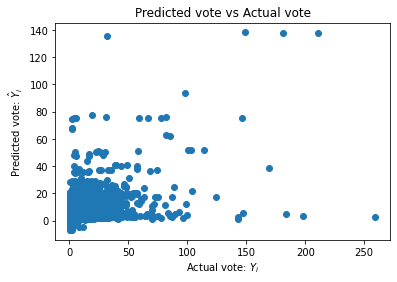

In [16]:
import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred_test_sgd)
plt.xlabel("Actual vote: $Y_i$")
plt.ylabel("Predicted vote: $\hat{Y}_i$")
plt.title("Predicted vote vs Actual vote")
plt.show()